In [1]:
import pandas as pd
import numpy as np 
import plotnine
import string
from pandasql import sqldf

pd.set_option('display.max_columns', None)

sb_data = pd.read_csv('../SB_dataset.csv')
se_data = pd.read_csv('../SE_dataset.csv')
pac_data = pd.read_csv('../data/raw/pacs_2024.csv') 
pac_financials = pd.read_csv('../data/processed/pac_financials.csv') 
cmte_data= pd.read_csv('../data/raw/committee_summary_2024.csv') 

/var/folders/cl/bdrh3m8j0fdfj6zm7zhhc2ch0000gn/T/ipykernel_44400/4258514516.py:9: DtypeWarning: Columns (3,4,7,8,9,10,11,16,18,20,21,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
/var/folders/cl/bdrh3m8j0fdfj6zm7zhhc2ch0000gn/T/ipykernel_44400/4258514516.py:10: DtypeWarning: Columns (3,4,10,11,16,34) have mixed types. Specify dtype option on import or set low_memory=False.


In [19]:
conduits = ['C00401224' #ActBlue 
            ,'C00694323' #WinRed
            ]
pac_cmte_tps = ['N' ,'O' ,'Q' ,'V','W']

pac_data = pac_data[pac_data['CMTE_TP'].isin(['N' ,'O' ,'Q' ,'V','W'])]

pac_data = pac_data[~pac_data['CMTE_ID'].isin(conduits)]

pac_data = pac_data[pac_data['TTL_DISB']>0]

In [20]:
pac_data.shape

(7873, 27)

## Data Cleaning

### Form Types
Form types code each expenditure into categories defined by the FEC. All form types in the SB (schedule B - expenditure) data should begin with the letters SB. 

Looking at the data there are 12 observations where this is not the case. 10 are associated with payments to ActBlue for credit card processing expenses. Given the small sample, I will drop all of these observations.  

SB17 isn't a disbursement lineitem associated with PAC filings. There is one observation with this coding from the 2023 Year End filing (1761077) from the Ryman Hospitality Properties Political Action Committee (C00183707). I'm going to drop this observation as well.

| Form Type       | Description         |
|-----------------|---------------------|
| SB21            | Operating Expenditures |
| SB21B           | Other Operating Expenditures |
| SB22            | Transfers to Affiliated  Other Party Committees |
| SB23            | Contributions to Fed. Candidates Committees and other political committees |
| SB26            | Loan repayments made |
| SB28A           | Refunds to Individuals |
| SB28B           | Refunds to Party Committees |
| SB28C           | Refunds to Other Committees |
| SB29            | Other Disbursements |
| SB30B           | Federal Election Activity |



### Form types should all start with SB

Each of the observations that do not fit this pattern have one observation each and the majority are related to credit card processing payments to ActBlue. I will drop these 9 observations 

| form_type        | Description                        |
|------------------|------------------------------------|
|

In [21]:
# examine unique form_types - they should all be SB 
sb_data.form_type.unique()

array(['SB23', 'SB21B', 'SB29', 'SB22', 'SB28A', 'SB28C', 'SB26', 'SB28B',
       'SB30B', 'SB21', 'SB27'], dtype=object)

In [22]:
# Examine observations where form_type does not start with SB
sb_data[(sb_data['form_type'].isin(['0417493', 'le',
        '18651', '1b', '493',  'O. Box 441146', 'AC',
       '6795', '46', 'et','SB17'])) | (sb_data['form_type'].isna())]

,form_type,filer_committee_id_number,transaction_id_number,back_reference_tran_id_number,back_reference_sched_name,entity_type,payee_organization_name,payee_last_name,payee_first_name,payee_middle_name,payee_prefix,payee_suffix,payee_street_1,payee_street_2,payee_city,payee_state,payee_zip_code,election_code,election_other_description,expenditure_date,expenditure_amount,semi_annual_refunded_bundled_amt,expenditure_purpose_descrip,category_code,beneficiary_committee_fec_id,beneficiary_committee_name,beneficiary_candidate_fec_id,beneficiary_candidate_last_name,beneficiary_candidate_first_name,beneficiary_candidate_middle_name,beneficiary_candidate_prefix,beneficiary_candidate_suffix,beneficiary_candidate_office,beneficiary_candidate_state,beneficiary_candidate_district,conduit_name,conduit_street_1,conduit_street_2,conduit_city,conduit_state,conduit_zip_code,memo_code,memo_text_description,reference_to_si_or_sl_system_code_that_identifies_the_account,filing_id,image_number,CMTE_ID,CMTE_TP


In [23]:
#only include observations where form_type startswith SB and is not null and not SB17
sb_data = sb_data[~sb_data['form_type'].isna()]
sb_data = sb_data[sb_data['form_type'].str.startswith('SB')]
sb_data = sb_data[sb_data['form_type']!='SB17']

In [24]:
sb_data.groupby('form_type').size().sort_values(ascending=False)

form_type
SB23     580590
SB21B    417374
SB29     152388
SB28A    116754
SB22      15473
SB28C       335
SB26        150
SB30B       147
SB28B        68
SB21         19
SB27          4
dtype: int64

### Make all numeric columns numeric 

In [25]:
sb_data['expenditure_amount'] = pd.to_numeric(sb_data['expenditure_amount'])

### Normalize all string data

In [26]:
def normalize_string_columns(df):
    """
    Function to normalize all string columns to uppercase 
    """
    for col in df.columns:
        if df[col].dtype == 'object':
           df[col] = (
           df[col]
           .str.replace(f"[{string.punctuation}]", " ", regex=True)
           .str.replace(r"\s+"," ", regex = True)
           .str.strip()
           .str.upper()
           )
    return df

sb_data = normalize_string_columns(sb_data) 
se_data = normalize_string_columns(se_data) 

## Cleaning SB22, SB23 lineitems 
a large part of this work will be looking at how much money is being spent directly supporting candidates vs. sending money around to interconnected PACs / Vendors, so we need to ensure the data from lineitems 22 and 23, which track disbursements to candidates/other committees and affiliated committees is complete. 

There are 385 observations that did not have either entity types or beneficiary committee IDs. I have manually coded these to entity types base on the payee organization name given the following criteria:
1. CCM: If the payee organization is a candidate name (Austin Scott) or a candidate committee name (Austin Scott for Congresss, (re)Elect X, Friends of Candidate etc.) or a candidate victory fund 
2. PTY: Readily identifiable as party committees 
3. PAC: If the payee organization is a business name (Bank of America), has the word PAC, or is not otherwise readily identifiable as a party committee or candidate. Leadership PACS were included as PACs 

In [27]:
disb_to_other_cmte = sb_data[sb_data['form_type'].isin(['SB23','SB22'])].copy()
disb_to_other_cmte.shape

(596063, 48)

In [28]:
disb_to_other_cmte['entity_type'].isna().sum()

0

In [29]:
disb_to_other_cmte['beneficiary_committee_fec_id'].isna().sum()

165254

In [30]:
len(disb_to_other_cmte[(disb_to_other_cmte['entity_type'].isna()) & (disb_to_other_cmte['beneficiary_committee_fec_id'].isna())])

0

In [31]:
# define mapping dictionaries

# for lineitems missing entity_type but with beneficiary_cmte_id,
# join cmte_data and map by cmte_tp
cmte_to_entity ={
    'O':'PAC'
    , 'Y': 'PTY'
    , 'Q': 'PAC'
    , 'I': 'PAC'
    , 'N': 'PAC'
    , 'H': 'CCM'
    , 'S': 'CCM'
    , 'X': 'PTY'
    , 'V': 'PAC'
    , 'P': 'CCM'
    , 'C': 'PAC'
    , 'W': 'PAC'
    , 'U': 'PAC'
}

# For lineitems missing both entity_type and any cmte_id,
# manually code 
payee_to_entity = {
'AARON BEAN FOR CONGRESS': 'CCM'
, 'ACBA JUDICIAL EXCELLENCE COMMITTEE': 'PAC'
, 'ACEC PAC': 'PAC'
, 'ALASKANS FOR DAN SULLIVAN': 'CCM'
, 'ALLEGHENY FAYETTE CLC': 'PAC'
, 'AMERICA S CREDIT UNIONS PAC': 'PAC'
, 'AMERICAN BANKERS ASSOCIATION PAC': 'PAC'
, 'ANDY ZAY FOR CONGRESS': 'CCM'
, 'ANGELA ALSOBROOKS FOR SENATE': 'CCM'
, 'ANGUS KING FOR US SENATE': 'CCM'
, 'APA FEDERAL PAC FUND': 'PAC'
, 'ARIZONA DEMOCRATIC PARTY': 'PTY'
, 'ARK PAC': 'PAC'
, 'ARTBA-PAC': 'PAC'
, 'AUSTIN SCOTT': 'CCM'
, 'AUSTIN SCOTT FOR CONGRESS': 'CCM'
, 'BACON, DONALD J': 'CCM'
, 'BANK OF AMERICA': 'PAC'
, 'BEN CLINE FOR CONGRESS': 'CCM'
, 'BIDEN VICTORY FUND': 'CCM'
, 'BILL CASSIDY FOR SENATE': 'CCM'
, 'BISHOP, SANFORD': 'CCM'
, 'BLUE HORIZON TEXAS': 'PAC'
, 'BOB CASEY FOR SENATE': 'CCM'
, 'BONNIE WATSON COLEMAN FOR CONGRESS': 'CCM'
, 'BOOZMAN FOR ARKANSAS': 'CCM'
, 'BRIAN BLAKE': 'CCM'
, 'BRIAN JACK FOR CONGRESS': 'CCM'
, 'BURGESS 4 UTAH': 'CCM'
, 'BURLISON FOR CONGRESS': 'CCM'
, 'CALIF ALLIANCE FOR RETIRED AMERICANS': 'PAC'
, 'CAMPAIGN CONTRIBUTION': 'CCM'
, 'CASEY KEYSTONE VICTORY FUND': 'CCM'
, 'CCDP-COMAL COUNTY DEMOCRATIC PARTY': 'PTY'
, 'CHAMBER PAC': 'PAC'
, 'CHESMARK': 'PAC'
, 'CHRIS COONS FOR DELAWARE': 'CCM'
, 'CHRIS MCDANIEL FOR STATE SENATE': 'CCM'
, 'CHRIS PAPPAS FOR CONGRESS': 'CCM'
, 'CIRB': 'PAC'
, 'CITIZENS FOR JASON ORTITAY': 'CCM'
, 'CITIZENS TO ELECT RICK LARSEN': 'CCM'
, 'CLIFF BENTZ FOR CONGRESS': 'CCM'
, 'COALITION FOR PROGRESS': 'PAC'
, 'COMER FOR CONGRESS': 'CCM'
, 'COMMITTEE TO ELECT ERIC FISHER': 'CCM'
, 'COMMITTEE TO ELECT MICHAEL WATSON': 'CCM'
, 'COMMITTEE TO ELECT PATRICK CAMPBELL': 'CCM'
, 'COMMITTEE TO ELECT SHANDA YATES': 'CCM'
, 'COMMITTEE TO ELECT WAYNE FONTANA': 'CCM'
, 'COMMITTEE TO RE-ELECT HENRY HANK JOHNSON': 'CCM'
, 'COMMITTEE TO REELECT BENGEL DISTRICT JUSTICE': 'CCM'
, 'COMMITTEE TO REELECT TARA SMITH': 'CCM'
, 'COMPLETE PARACHUTE SOLUTIONS': 'PAC'
, 'CONGRESSMAN BILL PASCRELL JR': 'CCM'
, 'CONGRESSMAN JODEY ARRINGTON': 'CCM'
, 'CONGRESSMAN JOSH GOTTHEIMER': 'CCM'
, 'CONGRESSMAN KEVIN KILEY (R-CA)': 'CCM'
, 'CONNECTICUT DEMOCRATIC STATE CENTRAL COMMITTEE': 'PTY'
, 'CONNOLLY FOR CONGRESS PAC': 'CCM'
, 'CONTRIBUTION': 'CCM'
, 'COWBOY VICTORY COMMITTEE II': 'PAC'
, 'CRAPO VICTORY COMMITTEE': 'CCM'
, 'CULAC': 'PAC'
, 'DAMON THAYER FOR STATE SENATE': 'CCM'
, 'DAN MEUSER FOR CONGRESS': 'CCM'
, 'DAN NEWHOUSE FOR CONGRESS': 'CCM'
, 'DARRELL ISSA FOR CONGRESS': 'CCM'
, 'DAVIDSON FOR CONGRESS': 'CCM'
, 'DCCC': 'PTY'
, 'DEAN KIRBY CAMPAIGN': 'CCM'
, 'DEBORAH ROSS FOR CONGRESS': 'CCM'
, 'DEL BENE FOR CONGRESS': 'CCM'
, 'DELBENE FOR CONGRESS': 'CCM'
, 'DESK PAC': 'PAC'
, 'DOVEN FOR PA': 'CCM'
, 'DUSTY JOHNSON': 'CCM'
, 'EASTERN MAINE LABOR COUNCIL': 'PAC'
, 'ELAINE DAVIS': 'CCM'
, 'ELECT JILL BECK': 'CCM'
, 'EMILIA SYKES FOR CONGRESS': 'CCM'
, 'EMMER MAJORITY BUILDERS': 'PAC'
, 'EMMER VICTORY FUND': 'CCM'
, 'ENGINEERS POLITICAL EDUCATION COMMITTEE': 'PAC'
, 'FEENSTRA, RANDY': 'CCM'
, 'FRANCOISE FOR AURORA CITY COUNCIL': 'CCM'
, 'FRENCH HILL FOR CONGRESS': 'CCM'
, 'FRIENDS OF AMY PAULIN': 'CCM'
, 'FRIENDS OF ANDY HARRIS': 'CCM'
, 'FRIENDS OF ANTHONY COLVILLE': 'CCM'
, 'FRIENDS OF ANTHONY DELUCA': 'CCM'
, 'FRIENDS OF AUSTIN DAVIS': 'CCM'
, 'FRIENDS OF BURKLEY ALLEN': 'CCM'
, 'FRIENDS OF COREY O CONNOR': 'CCM'
, 'FRIENDS OF DAN KILDEE': 'CCM'
, 'FRIENDS OF DAVE FAWCETT': 'CCM'
, 'FRIENDS OF DELBERT HOSEMAN': 'CCM'
, 'FRIENDS OF DEVLIN': 'CCM'
, 'FRIENDS OF DON BEYER': 'CCM'
, 'FRIENDS OF DUSTY JOHNSON': 'CCM'
, 'FRIENDS OF DUSTY JOHNSON FOR CONGRESS': 'CCM'
, 'FRIENDS OF GLENN THOMPSON': 'CCM'
, 'FRIENDS OF GT': 'CCM'
, 'FRIENDS OF JEFFREY ZURISKO FOR DISTRICT JUDGE': 'CCM'
, 'FRIENDS OF JOANNA MCCLINTON': 'CCM'
, 'FRIENDS OF JOE PITTMAN': 'CCM'
, 'FRIENDS OF JOE ROCKEY': 'CCM'
, 'FRIENDS OF JOE ROUGHY': 'CCM'
, 'FRIENDS OF JOHN CHRISTNER': 'CCM'
, 'FRIENDS OF JOHN WEINSTEIN': 'CCM'
, 'FRIENDS OF KEVIN KRAUS FOR SHERIFF': 'CCM'
, 'FRIENDS OF KHAN MOSLEY': 'CCM'
, 'FRIENDS OF LUCY MCBATH': 'CCM'
, 'FRIENDS OF MARIA': 'CCM'
, 'FRIENDS OF MATT BRADFORD': 'CCM'
, 'FRIENDS OF MATT BRUNGO': 'CCM'
, 'FRIENDS OF MATT FELDMEIER': 'CCM'
, 'FRIENDS OF MATTHEW BRUNO': 'CCM'
, 'FRIENDS OF MAZIE HIRONO': 'CCM'
, 'FRIENDS OF MIKE THATCHER': 'CCM'
, 'FRIENDS OF NICK': 'CCM'
, 'FRIENDS OF NICK SHERMAN': 'CCM'
, 'FRIENDS OF NICOLE ZICCARELLI': 'CCM'
, 'FRIENDS OF NINA RICARDI': 'CCM'
, 'FRIENDS OF PATTY KIM': 'CCM'
, 'FRIENDS OF RICH BOWERS': 'CCM'
, 'FRIENDS OF SHERROD BROWN': 'CCM'
, 'FRIENDS OF STEPHEN A ZAPPALA JR': 'CCM'
, 'FRIENDS OF STEPHEN ZAPPALA': 'CCM'
, 'FRIENDS OF STEPHEN ZAPPALA JR': 'CCM'
, 'GABE AMO FOR CONGRESS': 'CCM'
, 'GARBARINO FOR CONGRESS': 'CCM'
, 'GARRITY FOR PA': 'CCM'
, 'GATEWAY TO LEADERSHIP PAC': 'PAC'
, 'GAYDOS FOR PA': 'CCM'
, 'GEORGE LATIMER FOR CONGRESS': 'CCM'
, 'GERRY CONNOLLY FOR CONGRESS': 'CCM'
, 'GLEN F IVEY FOR CONGRESS': 'CCM'
, 'GLENN THOMPSON': 'CCM'
, 'GLORIA JOHNSON': 'CCM'
, 'GONZALES, TONY': 'CCM'
, 'GREATER TOMORROW PAC': 'PAC'
, 'GREG CASAR FOR CONGRESS': 'CCM'
, 'GREG STEUBE FOR CONGRESS': 'CCM'
, 'HARKINS FOR MISSISSIPPI': 'CCM'
, 'HAWKEYE PAC': 'PAC'
, 'HENRICO COUNTY DEMOCRATIC COMMITTEE': 'PTY'
, 'HILARY FRANZ FOR CONGRESS': 'CCM'
, 'HOEVEN FOR SENATE': 'CCM'
, 'HOUSE CONSERVATIVE FUND': 'PAC'
, 'HOYER FOR CONGRESS': 'CCM'
, 'IBEW PAC': 'PAC'
, 'ILLINOIS NEVADA 2023 FUND': 'PAC'
, 'JACKSON, RONNY': 'CCM'
, 'JACKY ROSEN VICTORY FUND': 'CCM'
, 'JAKE ELLZEY VICTORY FUND': 'CCM'
, 'JAMES COMER FOR CONGRESS': 'CCM'
, 'JASON HOWELL FOR STATE SENATE': 'CCM'
, 'JASON SMITH FOR CONGRESS': 'CCM'
, 'JAY COSTA': 'CCM'
, 'JAY COSTA FOR STATE SENATE': 'CCM'
, 'JEFF JACKSON FOR CONGRESS': 'CCM'
, 'JEFFRIES FOR CONGRESS': 'CCM'
, 'JIM JORDAN FOR CONGRESS': 'CCM'
, 'JODY ROGISH FOR TUCKAHOE': 'CCM'
, 'JOE KENT VICTORY FUND': 'CCM'
, 'JOHN MOOLENAAR FOR CONGRESS': 'CCM'
, 'JOHN WEINSTEIN': 'CCM'
, 'JONI FOR IOWA': 'CCM'
, 'JOSH GOTTHEIMER FOR CONGRESS': 'CCM'
, 'KAINE FOR COMMOM GROUND PAC': 'CCM'
, 'KAINE VICTORY FUND': 'CCM'
, 'KAREN CRNKOVICH FOR CONGRESS': 'CCM'
, 'KBA PAC FOR 2023': 'PAC'
, 'KBA PAC FOR 2024': 'PAC'
, 'KEEP JUDGE MELOGRANE': 'PAC'
, 'KLOBUCHAR FOR MINNESOTA': 'CCM'
, 'KLOBUCHER, AMY': 'CCM'
, 'KUNSEIMAN FOR PA': 'CCM'
, 'KWEISI MFUME FOR CONGRESS': 'CCM'
, 'KY SENATE REPUBLICAN CAMPAIGN CAUCUS COMMITTEE': 'PAC'
, 'LAHOOD FOR CONGRESS': 'CCM'
, 'LARRY MAGGI ELECTION COMMITTEE': 'CCM'
, 'LAWSON FOR AURORA CITY COUNCIL': 'CCM'
, 'LUCAS FOR CONGRESS': 'CCM'
, 'LUCAS KUNCE FOR MISSOURI': 'CCM'
, 'LYNN FITCH FOR MISSISSIPPI': 'CCM'
, 'MADISON PROJECT': 'PAC'
, 'MAINE AFL CIO': 'PAC'
, 'MAINE PEOPLE S ALLIANCE': 'PAC'
, 'MANLY BARTON CAMPAIGN': 'CCM'
, 'MARGARITA WILKINSON FOR CONGRESS': 'CCM'
, 'MARIE GLUESENKAMP PEREZ': 'CCM'
, 'MARK PODY': 'CCM'
, 'MARTIN PACE CAMPAIGN': 'CCM'
, 'MATT BECK FOR MAINE HOUSE': 'CCM'
, 'MAURICE HUDSON FOR JUDGE': 'CCM'
, 'MAX FOR INDIANA': 'CCM'
, 'MCCAFFREY FOR SUPREME COURT': 'CCM'
, 'MEGAN BARRY': 'CCM'
, 'MICHAEL MEREDITH FOR STATE REPRESENTATIVE': 'CCM'
, 'MIKE BOST FOR CONGRESS': 'CCM'
, 'MIKE CAREY FOR CONGRESS': 'CCM'
, 'MIKE COLLINS': 'CCM'
, 'MIKE GARCIA FOR CONGRESS': 'CCM'
, 'MIKE KELLY FOR CONGRESS': 'CCM'
, 'MIKE NEMES FOR STATE SENATE': 'CCM'
, 'MIKE ROGERS FOR CONGRESS': 'CCM'
, 'MIKE THOMPSON FOR CONGRESS': 'CCM'
, 'MIKIE SHERRILL FOR CONGRESS': 'CCM'
, 'MILLER WENHOLD ASSOCIATION MANAGEMENT': 'PAC'
, 'MONICA DE LA CRUZ FOR CONGRESS': 'CCM'
, 'MONTANA S ELECTRIC COOPERATIONS PAC': 'PAC'
, 'MONTANA S ELECTRIC COOPERATIVES PAC': 'PAC'
, 'MOOLENAAR FOR CONGRESS': 'CCM'
, 'MOORE, DAVID': 'CCM'
, 'MORAN FOR CONGRESS': 'CCM'
, 'NACDS-PAC': 'PAC'
, 'NADLER FOR CONGRESS': 'CCM'
, 'NADLER FOR CONGRESS INC': 'CCM'
, 'NAMIC PAC': 'PAC'
, 'NATHANIEL MORAN FOR CONGRESS': 'CCM'
, 'NATIONAL MILK PRODUCERS FEDERATION PAC': 'PAC'
, 'NBWA PAC FOR 2023': 'PAC'
, 'NEBRASKA CREDIT UNION LEAGUE LEGISLATIVE ACTION COMM': 'PAC'
, 'NEW JERSEY DEMOCRATIC STATE COMMITTEE - FEDERAL': 'PTY'
, 'NEW JERSEY STATE DEMOCRATIC COMMITTEE': 'PTY'
, 'NEWHOUSE, DANIEL': 'CCM'
, 'NIKKI FOR CONGRESS': 'CCM'
, 'NORTH DAKOTA BANKERS ASSOCIATION PAC - STATE': 'PAC'
, 'OHIO RESTAURANT ASSOCIATION': 'PAC'
, 'PA CHAMBER PAC': 'PAC'
, 'PASCRELL FOR CONGRESS': 'CCM'
, 'PATTY MURRAY FOR SENATE': 'CCM'
, 'PEC PENNY FUND': 'PAC'
, 'PEOPLE FOR DEREK KILMER': 'CCM'
, 'PEOPLE FOR PALMIERE': 'CCM'
, 'PEOPLE FOR PATTY MURRAY': 'CCM'
, 'PNC BANK': 'PAC'
, 'POLITICAL ACTION COUNCIL OF EDUCATORS SPONSORED BY TEACHER UNIONS, INCLUDING UNITED TEACHERS LOS ANGELES': 'PAC'
, 'PRAMILA FOR CONGRESS': 'CCM'
, 'RASHIDA TLAIB FOR CONGRESS': 'CCM'
, 'RAY HARTMANN FOR CONGRESS': 'CCM'
, 'RE-ELECT MCGOVERN COMMITTEE': 'CCM'
, 'REPRESENTATIVE REYNEVELD FOR CITY COUNCIL': 'CCM'
, 'REPUBLICAN COMMITTEE OF ALLEGHEY COUNTY': 'PTY'
, 'REPUBLICAN STATE LEADERSHIP COMMITTEE': 'PAC'
, 'RESCHENTHALER VICTORY FUND': 'CCM'
, 'RI DEMOCRATIC PARTY': 'PTY'
, 'ROGER MARTIN FOR JUDGE': 'CCM'
, 'ROGER WILLIAMS FOR CONGRESS': 'CCM'
, 'RON ESTES FOR CONGRESS': 'CCM'
, 'SABINA FOR RI': 'CCM'
, 'SALUD CARBAJAL FOR CONGRESS': 'CCM'
, 'SAM GRAVES FOR CONGRESS': 'CCM'
, 'SANFORD BISHOP FOR CONGRESS': 'CCM'
, 'SCHMITT FOR SENATE': 'CCM'
, 'SCHNEIDER FOR CONGRESS': 'CCM'
, 'SCHULTZ, JENNIFER': 'CCM'
, 'SCOTT FITZGERALD FOR CONGRESS': 'CCM'
, 'SENATE REPUBLICAN CAUCUS CAMPAIGN COMM': 'PAC'
, 'SENATOR MURRAY FOR SENATE': 'CCM'
, 'SENATOR TED CRUZ': 'CCM'
, 'SEXTON FOR STATE REPRESENTATIVE': 'CCM'
, 'SHERI BIGGS FOR CONGRESS': 'CCM'
, 'SINEMA FOR ARIZONA': 'CCM'
, 'SMITH, WESLEY J': 'CCM'
, 'SMUCKER, LLOYD': 'CCM'
, 'SOUTHERN MAINE LABOR COUNCIL': 'PAC'
, 'TAMMY BALDWIN FOR SENATE': 'CCM'
, 'TEAM JOYCE FOR PENNSYLVANIA': 'CCM'
, 'TEAM MCCORMICK': 'CCM'
, 'TEXANS FOR HENRY CUELLAR': 'CCM'
, 'TEXANS FOR RONNY JACKSON': 'CCM'
, 'TEXANS FOR SENATOR JOHN CORNYN': 'CCM'
, 'THE REED COMMITTEE': 'CCM'
, 'THOMPAC': 'PAC'
, 'THOMPSON, GLENN': 'CCM'
, 'TOKUDA FOR HAWAII': 'CCM'
, 'TREY LAMAR CAMPAIGN': 'CCM'
, 'TUBERVILLE FOR SENATE': 'CCM'
, 'UA PEC PENNY FUND': 'PAC'
, 'UNITED PAC': 'PAC'
, 'US CONGRESSMAN TONY GONZALEZS': 'CCM'
, 'VAN ORDEN FOR CONGRESS': 'CCM'
, 'VICENTE GONZALEZ FOR CONGRESS': 'CCM'
, 'VOTE JEFF WOODARD': 'CCM'
, 'VOTE NEFT': 'PAC'
, 'WASHINGTON CO GOOD GOVERNMENT PAC': 'PAC'
, 'WEBER FOR CONGRESS': 'CCM'
, 'WESTERMAN VICTORY FUND': 'CCM'
, 'WHITEHOUSE FOR SENATE': 'CCM'
, 'WHITEHOUSE VICTORY FUND': 'CCM'
, 'WICKER FOR SENATE': 'CCM'
, 'WICKER, ROGER F': 'CCM'
, 'WILFREDO RIVERA': 'CCM'
, 'WILLIAM LAMBERTH': 'CCM'
, 'ZACH NUNN FOR CONGRESS': 'CCM'
, 'SCHULTZ JENNIFER': 'CCM'
, 'KLOBUCHER AMY': 'CCM'
, 'TTD PAC': 'PAC'
, 'NBWA PAC FOR 2024': 'PAC'
, 'COMMITTEE TO RE ELECT HENRY HANK JOHNSON': 'CCM'
, 'BOOZMAN SEN JOHN': 'CCM'
, 'NEWHOUSE DANIEL': 'CCM'
, 'SMUCKER LLOYD': 'CCM'
, 'GONZALES TONY': 'CCM'
, 'BISHOP SANFORD': 'CCM'
, 'JACKSON RONNY': 'CCM'
, 'MOORE DAVID': 'CCM'
, 'NEW JERSEY DEMOCRATIC STATE COMMITTEE FEDERAL': 'PTY'
, 'COLLINS VICTORY COMMITTEE': 'CCM'
, 'ARTBA PAC': 'PAC'
, 'SMITH WESLEY J': 'CCM'
, 'COLLINS FOR CONGRESS': 'CCM'
, 'SCOTT BOBBY': 'CCM'
, 'POLITICAL ACTION COUNCIL OF EDUCATORS SPONSORED BY TEACHER UNIONS INCLUDING UNITED TEACHERS LOS ANGELES': 'PAC'
, 'NACDS PAC': 'PAC'
, 'RE ELECT MCGOVERN COMMITTEE': 'CCM'
, 'FEENSTRA RANDY': 'CCM'
, 'BACON DONALD J': 'CCM'
, 'NORTH DAKOTA BANKERS ASSOCIATION PAC STATE': 'PAC'
, 'CONGRESSMAN KEVIN KILEY R CA': 'CCM'
, 'THOMPSON GLENN': 'CCM'
, 'WICKER ROGER F': 'CCM'
, 'CCDP COMAL COUNTY DEMOCRATIC PARTY' : 'PTY'


}

## some also missing payee information, given beneficiary_candidate_last_name, code as cand
cand_last_entity = {
    'PHELAN':'CCM'
    , 'ASHBY':'CCM'
    , 'HARRIS':'CCM'
    , 'BAILES':'CCM'
    , 'BURNS':'CCM'
    , 'DEAN':'CCM'
    , 'VANDEAVER':'CCM'
    , 'KIRBY':'CCM'
    , 'THOMPSON':'CCM'
    , 'NEWHOUSE':'CCM'
}

In [32]:
# deal with duplicate data values in cmte_data before joining 
cmte_data_sm = cmte_data[['CMTE_ID','CMTE_TP','TTL_RECEIPTS']].copy().drop_duplicates()
cmte_data_sm["rank_max"] = cmte_data_sm.groupby(['CMTE_ID','CMTE_TP'])["TTL_RECEIPTS"].rank(method="max", ascending=False)
cmte_data_sm.groupby('CMTE_ID').nunique().sort_values(by='CMTE_TP', ascending=False)

,CMTE_TP,TTL_RECEIPTS,rank_max
CMTE_ID,,,
C00000059,1,1,1
C00823286,1,1,1
C00823120,1,1,1
C00823146,1,1,1
C00823153,1,1,1
...,...,...,...
C00611202,1,1,1
C00611400,1,1,1
C00611517,1,1,1


In [33]:
sb_data.shape

(1283302, 48)

In [34]:
# join cmte_data to sb_data to include cmte_tps for observations missing entity_tps but not beneficiary fec ids
sb_data = sb_data.merge(cmte_data_sm[['CMTE_ID','CMTE_TP']]
                                              , how = 'left'
                                              , left_on = 'beneficiary_committee_fec_id'
                                              , right_on='CMTE_ID')
sb_data.shape

(1283302, 50)

In [38]:
sb_data.columns

Index(['form_type', 'filer_committee_id_number', 'transaction_id_number',
       'back_reference_tran_id_number', 'back_reference_sched_name',
       'entity_type', 'payee_organization_name', 'payee_last_name',
       'payee_first_name', 'payee_middle_name', 'payee_prefix', 'payee_suffix',
       'payee_street_1', 'payee_street_2', 'payee_city', 'payee_state',
       'payee_zip_code', 'election_code', 'election_other_description',
       'expenditure_date', 'expenditure_amount',
       'semi_annual_refunded_bundled_amt', 'expenditure_purpose_descrip',
       'category_code', 'beneficiary_committee_fec_id',
       'beneficiary_committee_name', 'beneficiary_candidate_fec_id',
       'beneficiary_candidate_last_name', 'beneficiary_candidate_first_name',
       'beneficiary_candidate_middle_name', 'beneficiary_candidate_prefix',
       'beneficiary_candidate_suffix', 'beneficiary_candidate_office',
       'beneficiary_candidate_state', 'beneficiary_candidate_district',
       'conduit_name

In [36]:
# use dictionaries to map data etc etc 
sb_data['entity_type'] = sb_data['entity_type'].fillna(  
    sb_data['CMTE_TP'].map(cmte_to_entity)  # Map cmte_tp to entity_tp if available
).fillna(  # If still NaN, map payee_organization_name to entity_tp
    sb_data['payee_organization_name'].map(payee_to_entity)
).fillna (sb_data['beneficiary_candidate_last_name'].map(cand_last_entity)) # the rest of the null values are candidates (candidate name columns are full)

KeyError: 'CMTE_TP'

In [81]:
# check there are no longer missing entity_types 
sb_data[sb_data['form_type'].isin(['SB23','SB22'])]['entity_type'].isna().sum()


0

In [32]:
sb_data[sb_data['form_type'].isin(['SB23','SB22'])].groupby('entity_type').size()

entity_type
CAN      2482
CCM    532326
COM      4298
IND      2459
ORG      3928
PAC     42817
PTY      7753
dtype: int64

In [82]:
print('# committees with SB details:',sb_data.filer_committee_id_number.nunique())
print('# filings:',sb_data.filing_id.nunique())
print('# expenses:',sb_data.size)
print('$ spent:', sb_data.expenditure_amount.sum())

# committees with SB details: 7126
# filings: 42495
# expenses: 61598496
$ spent: 6541790885.799998


## SE Exploration

In [83]:
se_data.head()

,form_type,filer_committee_id_number,transaction_id_number,back_reference_tran_id_number,back_reference_sched_name,entity_type,payee_organization_name,payee_last_name,payee_first_name,payee_middle_name,payee_prefix,payee_suffix,payee_street_1,payee_street_2,payee_city,payee_state,payee_zip_code,election_code,election_other_description,dissemination_date,expenditure_amount,disbursement_date,calendar_y_t_d_per_election_office,expenditure_purpose_descrip,category_code,payee_cmtte_fec_id_number,support_oppose_code,candidate_id_number,candidate_last_name,candidate_first_name,candidate_middle_name,candidate_prefix,candidate_suffix,candidate_office,candidate_district,candidate_state,completing_last_name,completing_first_name,completing_middle_name,completing_prefix,completing_suffix,date_signed,memo_code,memo_text_description,filing_id,image_number
0,SE,C00867945,SE 4477,NaN,NaN,ORG,GOOGLE LLC,NaN,NaN,NaN,NaN,NaN,1600 AMPHITHEATRE PARKWAY,NaN,MOUNTAINVIEW,CA,94043,G2024,NaN,NaN,500.0,2024 10 18,500.0,GOOGLE ADS VIDEO ADVERTISING,4,C00867945,O,P80001571,TRUMP,DONALD,J,NaN,NaN,P,NaN,NaN,RYAN,TIM,NaN,NaN,NaN,2024 12 06,NaN,NaN,1859311,NaN
1,SE,C00867945,SE 4478,NaN,NaN,ORG,GOOGLE LLC,NaN,NaN,NaN,NaN,NaN,1600 AMPHITHEATRE PARKWAY,NaN,MOUNTAINVIEW,CA,94043,G2024,NaN,NaN,500.0,2024 10 20,1000.0,GOOGLE ADS DIGITAL VIDEO ADVERTISING,4,C00867945,O,P80001571,TRUMP,DONALD,J,NaN,NaN,P,NaN,NaN,RYAN,TIM,NaN,NaN,NaN,2024 12 06,NaN,NaN,1859311,NaN
2,SE,C00867945,SE 4479,NaN,NaN,ORG,GOOGLE LLC,NaN,NaN,NaN,NaN,NaN,1600 AMPHITHEATRE PARKWAY,NaN,MOUNTAINVIEW,CA,94043,G2024,NaN,NaN,500.0,2024 10 21,1500.0,GOOGLE ADS DIGITAL VIDEO ADVERTISING,4,C00867945,O,P80001571,TRUMP,DONALD,J,NaN,NaN,P,NaN,NaN,RYAN,TIM,NaN,NaN,NaN,2024 12 06,NaN,NaN,1859311,NaN
3,SE,C00867945,SE 4480,NaN,NaN,ORG,GOOGLE LLC,NaN,NaN,NaN,NaN,NaN,1600 AMPHITHEATRE PARKWAY,NaN,MOUNTAINVIEW,CA,94043,G2024,NaN,NaN,500.0,2024 10 23,2000.0,GOOGLE ADS DIGITAL VIDEO ADVERTISING,4,C00867945,O,P80001571,TRUMP,DONALD,J,NaN,NaN,P,NaN,NaN,RYAN,TIM,NaN,NaN,NaN,2024 12 06,NaN,NaN,1859311,NaN
4,SE,C00867945,SE 4481,NaN,NaN,ORG,GOOGLE LLC,NaN,NaN,NaN,NaN,NaN,1600 AMPHITHEATRE PARKWAY,NaN,MOUNTAINVIEW,CA,94043,G2024,NaN,NaN,500.0,2024 10 24,2500.0,GOOGLE ADS DIGITAL VIDEO ADVERTISING,4,C00867945,O,P80001571,TRUMP,DONALD,J,NaN,NaN,P,NaN,NaN,RYAN,TIM,NaN,NaN,NaN,2024 12 06,NaN,NaN,1859311,NaN


In [84]:
print('# committees with SE details:',se_data.filer_committee_id_number.nunique())
print('# filings:',se_data.filing_id.nunique())
print('# expenses:',se_data.size)
print('$ spent:', se_data.expenditure_amount.sum())

# committees with SE details: 867
# filings: 2234
# expenses: 2441312
$ spent: 3421899774.68


In [85]:
# aggregate spending by committee id 
se_cmte = se_data.groupby('filer_committee_id_number')['expenditure_amount'].sum().sort_values(ascending = False).reset_index()
se_cmte.rename(columns={'filer_committee_id_number':'cmte_id','expenditure_amount':'se_amt'}, inplace=True)

## Aggregate Data to create topline numbers
By committee:
- total number of vendors
- percent of money spent on 1 vendor 
- Number of vendors receive X% of spending 

In [86]:
sb_data['payee_organization_name'].isna().sum()

180518

In [87]:
# create column that has a payee name based on first payee_org, then payee_name (employees/consultants/etc), then beneficiary_cand_name
sb_data['payee_name'] = sb_data['payee_last_name'].astype(str)+sb_data['payee_first_name'].astype(str)+sb_data['payee_city'].astype(str)
sb_data['beneficiary_cand_name'] = sb_data['beneficiary_candidate_first_name'].astype(str)+sb_data['beneficiary_candidate_last_name'].astype(str)
sb_data['payee_id'] = sb_data[['payee_organization_name', 'payee_name', 'beneficiary_cand_name']].bfill(axis=1).iloc[:, 0]


In [88]:
# Create df that looks at distribution of spending across payees, for all spending and just operating expenditure
query = """
SELECT 
filer_committee_id_number as cmte_id
, payee_id
, sum(expenditure_amount) as total_expenditure
, min(case when form_type!='SB22' and form_type !='SB23' then 1 else 0 end) as is_opp_vendor
FROM sb_data

group by 1,2
order by 1,3 desc 
"""

sb_cmte_vendor_agg = sqldf(query)


sb_cmte_vendor_agg["running_ttl"] = sb_cmte_vendor_agg.groupby("cmte_id")["total_expenditure"].cumsum()
sb_cmte_vendor_agg["running_ttl_opp"] = sb_cmte_vendor_agg.query('is_opp_vendor==1').groupby("cmte_id")["total_expenditure"].cumsum()

sb_cmte_vendor_agg["ttl"] = sb_cmte_vendor_agg.groupby("cmte_id")["total_expenditure"].transform('sum')
sb_cmte_vendor_agg["ttl_opp"] = sb_cmte_vendor_agg.query('is_opp_vendor==1').groupby("cmte_id")["total_expenditure"].transform('sum')

sb_cmte_vendor_agg['running_ttl_opp'] = sb_cmte_vendor_agg.groupby('cmte_id')['running_ttl_opp'].fillna(method='ffill').fillna(0)
sb_cmte_vendor_agg['ttl_opp'] = sb_cmte_vendor_agg.groupby('cmte_id')['running_ttl_opp'].fillna(method='ffill').fillna(0)

sb_cmte_vendor_agg["pct_running_ttl"] = sb_cmte_vendor_agg['running_ttl']/sb_cmte_vendor_agg["ttl"]
sb_cmte_vendor_agg["pct_running_ttl_opp"] = sb_cmte_vendor_agg['running_ttl_opp']/sb_cmte_vendor_agg["ttl"]

sb_cmte_vendor_agg["running_vendor_count"] = sb_cmte_vendor_agg.groupby("cmte_id").cumcount() + 1
sb_cmte_vendor_agg["running_opp_vendor_count"] = sb_cmte_vendor_agg.groupby('cmte_id')['is_opp_vendor'].cumsum()




/var/folders/cl/bdrh3m8j0fdfj6zm7zhhc2ch0000gn/T/ipykernel_10104/420061057.py:23: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
/var/folders/cl/bdrh3m8j0fdfj6zm7zhhc2ch0000gn/T/ipykernel_10104/420061057.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/var/folders/cl/bdrh3m8j0fdfj6zm7zhhc2ch0000gn/T/ipykernel_10104/420061057.py:24: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
/var/folders/cl/bdrh3m8j0fdfj6zm7zhhc2ch0000gn/T/ipykernel_10104/420061057.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a fu

In [89]:
sb_cmte_vendor_agg.query("cmte_id=='C99002396'")

,cmte_id,payee_id,total_expenditure,is_opp_vendor,running_ttl,running_ttl_opp,ttl,ttl_opp,pct_running_ttl,pct_running_ttl_opp,running_vendor_count,running_opp_vendor_count
304002,C99002396,RED SPARK STRATEGY,547829.90,1,547829.90,547829.90,2698481.95,547829.90,0.203014,0.203014,1,1
304003,C99002396,BETTER MOUSETRAP DIGITAL,366708.21,1,914538.11,914538.11,2698481.95,914538.11,0.338908,0.338908,2,2
304004,C99002396,DONORBUREAU,246369.56,1,1160907.67,1160907.67,2698481.95,1160907.67,0.430208,0.430208,3,3
304005,C99002396,TMA DIRECT,237978.04,1,1398885.71,1398885.71,2698481.95,1398885.71,0.518397,0.518397,4,4
304006,C99002396,FRONTLINE STRATEGIES LLC,202645.60,1,1601531.31,1601531.31,2698481.95,1601531.31,0.593493,0.593493,5,5
304007,C99002396,WINRED TECHNICAL SERVICES,182060.69,1,1783592.00,1783592.00,2698481.95,1783592.00,0.660961,0.660961,6,6
304008,C99002396,RRTV MEDIA,178500.00,1,1962092.00,1962092.00,2698481.95,1962092.00,0.727110,0.727110,7,7
304009,C99002396,CONSERVATIVE CONNECTOR LLC,142880.08,1,2104972.08,2104972.08,2698481.95,2104972.08,0.780058,0.780058,8,8
304010,C99002396,OLYMPIC MEDIA,126831.91,1,2231803.99,2231803.99,2698481.95,2231803.99,0.827059,0.827059,9,9
304011,C99002396,CAMPAGIN DATA GROUP,126664.95,1,2358468.94,2358468.94,2698481.95,2358468.94,0.873998,0.873998,10,10


In [90]:
# create dataframe that determines how many vendors make up 50-75-90 percent of all spending 
# assumption is that scam pacs will have lower numbers compared to non-scam pacs
# especially looking at the _opp_ values which will exclude contributions to candidates/cmtes
query = """
  SELECT 
  cmte_id 
  , max(running_vendor_count) as n_vendors
  , max(case when running_vendor_count=1 then pct_running_ttl end) as pct_to_top_vendor
  , min(case when pct_running_ttl>=.5 then running_vendor_count end ) as n_vendors_50_pct
  , min(case when pct_running_ttl>=.75 then running_vendor_count end ) as n_vendors_75_pct
  , min(case when pct_running_ttl>=.95 then running_vendor_count end ) as n_vendors_90_pct
  , sum(total_expenditure) as ttl_expenditures

  , max(running_opp_vendor_count) as n_opp_vendors
  , max(case when running_opp_vendor_count=1 then pct_running_ttl_opp end) as pct_to_top_opp_vendor
  , min(case when pct_running_ttl_opp>=.5 then running_opp_vendor_count end ) as n_opp_vendors_50_pct
  , min(case when pct_running_ttl_opp>=.75 then running_opp_vendor_count end ) as n_opp_vendors_75_pct
  , min(case when pct_running_ttl_opp>=.95 then running_opp_vendor_count end ) as n_opp_vendors_90_pct
  , sum(case when is_opp_vendor = 1 then total_expenditure else 0 end) as ttl_opp_expenditures
  FROM sb_cmte_vendor_agg
  group by 1
  """
sb_cmte_vendor_agg_by_cmte = sqldf(query)



In [91]:
sb_cmte_vendor_agg_by_cmte.sort_values(['n_opp_vendors_50_pct','ttl_expenditures'],ascending=[True,False]).head(25)

,cmte_id,n_vendors,pct_to_top_vendor,n_vendors_50_pct,n_vendors_75_pct,n_vendors_90_pct,ttl_expenditures,n_opp_vendors,pct_to_top_opp_vendor,n_opp_vendors_50_pct,n_opp_vendors_75_pct,n_opp_vendors_90_pct,ttl_opp_expenditures
6676,C00879510,116,0.638734,1.0,8.0,25.0,81425070.26,116,0.638734,1.0,8.0,25.0,81425070.26
5492,C00825851,174,0.636755,1.0,2.0,23.0,39261596.42,173,0.636755,1.0,2.0,25.0,38836596.42
6821,C00883520,18,0.803745,1.0,1.0,5.0,32428773.28,17,0.803745,1.0,1.0,5.0,32228773.28
4305,C00750521,448,0.644341,1.0,2.0,3.0,23404486.55,445,0.644341,1.0,NaN,NaN,16828217.46
1493,C00365536,612,0.501830,1.0,13.0,93.0,10059231.11,503,0.501830,1.0,14.0,NaN,9278139.02
3491,C00657866,23,0.628692,1.0,4.0,10.0,9718141.36,20,0.628692,1.0,4.0,NaN,8618141.36
4982,C00799031,60,0.573209,1.0,3.0,9.0,9695238.92,57,0.573209,1.0,24.0,NaN,7295238.92
3822,C00693515,219,0.547016,1.0,10.0,51.0,9004343.52,207,0.547016,1.0,13.0,104.0,8610641.21
3369,C00636027,168,0.610066,1.0,4.0,44.0,8829133.71,168,0.610066,1.0,4.0,44.0,8829133.71
4941,C00794396,20,0.539894,1.0,3.0,8.0,8726195.52,18,0.539894,1.0,NaN,NaN,6526195.52


In [92]:
# create a new df to aggregate contributions to other cmtes at the spending cmte level 
cand_other_cmte_spend = sb_data[sb_data.form_type.isin(['SB23','SB22'])].groupby(['filer_committee_id_number','entity_type'])['expenditure_amount'].sum().sort_values(ascending=False).reset_index()

In [93]:
# reclassify entity types to be either cand, pac, pty, or ind
cand_other_cmte_spend['entity_group'] = np.where(cand_other_cmte_spend['entity_type'].isin(['CCM','CAN']),'CAN',
                                                 np.where(cand_other_cmte_spend['entity_type'].isin(['ORG','PAC','COM']),'PAC',cand_other_cmte_spend['entity_type']))
cand_other_cmte_spend = cand_other_cmte_spend.groupby(['filer_committee_id_number','entity_group'])['expenditure_amount'].sum().sort_values(ascending=False).reset_index()



In [94]:
# get rid of negative spending values 
cand_other_cmte_spend['expenditure_amount'] = np.where(cand_other_cmte_spend['expenditure_amount']<0,0,cand_other_cmte_spend['expenditure_amount'])

In [95]:
# pivot data 
cand_other_cmte_spend_wide = cand_other_cmte_spend.pivot(index='filer_committee_id_number', columns='entity_group', values='expenditure_amount')

cand_other_cmte_spend_wide

entity_group,CAN,IND,PAC,PTY
filer_committee_id_number,,,,
C00000059,85000.0,NaN,12500.00,NaN
C00000422,493400.0,NaN,233500.00,60000.0
C00000729,1413500.0,NaN,956000.00,NaN
C00000885,793100.0,NaN,520043.65,87500.0
C00000901,1583000.0,NaN,477500.00,195000.0
...,...,...,...,...
C00892414,NaN,NaN,0.00,NaN
C00893081,5000.0,NaN,NaN,NaN
C00893230,33000.0,NaN,22500.00,NaN


### Merge all cmte level datasets
1. vendor_agg_by_cmte - looking at the distribution of spending across vendors
2. cand_other_cmte_spend_wide - looking at where contributions to other cmtes are going
3. se_cmte - IE spending by cmte
4. exp_cat - by cmte, how much of their non-contribution spending was in specified categories 
5. pact_financials - by cmte, what % of their contributions were rasied from unitemized $?

In [96]:
pac_data_merge = pac_data.merge(
    sb_cmte_vendor_agg_by_cmte
    , how ='left'
    , left_on = 'CMTE_ID'
    , right_on = 'cmte_id'
)

pac_data_merge = pac_data_merge.merge(
    cand_other_cmte_spend_wide
    , how ='left'
    , left_on = 'CMTE_ID'
    , right_on = 'filer_committee_id_number'
)

pac_data_merge = pac_data_merge.merge(
    se_cmte
    , how ='left'
    , left_on = 'CMTE_ID'
    , right_on = 'cmte_id'
)

pac_data_merge = pac_data_merge.merge(
    pac_financials[['committee_id'
                    , 'individual_unitemized_contributions'
                    , 'individual_itemized_contributions'
                    , 'individual_contributions']]
    , how ='left'
    , left_on = 'CMTE_ID'
    , right_on = 'committee_id'
)

In [97]:
exp_cat = pd.read_csv('../data/processed/cmte_exp_cat_agg.csv')

pac_data_merge = pac_data_merge.merge(
    exp_cat
    , how ='left'
    , left_on = 'CMTE_ID'
    , right_on = 'filer_committee_id_number'
)

In [98]:
pac_data_merge.columns

Index(['CMTE_ID', 'CMTE_NM', 'CMTE_TP', 'CMTE_DSGN', 'CMTE_FILING_FREQ',
       'TTL_RECEIPTS', 'TRANS_FROM_AFF', 'INDV_CONTRIB',
       'OTHER_POL_CMTE_CONTRIB', 'CAND_CONTRI', 'CAND_LOANS',
       'TTL_LOANS_RECEIVED', 'TTL_DISB', 'TRANF_TO_AFF', 'INDV_REFUNDS',
       'OTHER_POL_CMTE_REFUNDS', 'CAND_LOAN_REPAY', 'LOAN_REPAY', 'COH_BOP',
       'COH_COP', 'DEBTS_OWED_BY', 'NONFED_TRANS_RECEIVED',
       'CONTRIB_TO_OTHER_CMTE', 'IND_EXP', 'PTY_COORD_EXP', 'NONFED_SHARE_EXP',
       'CVG_END_DT', 'cmte_id_x', 'n_vendors', 'pct_to_top_vendor',
       'n_vendors_50_pct', 'n_vendors_75_pct', 'n_vendors_90_pct',
       'ttl_expenditures', 'n_opp_vendors', 'pct_to_top_opp_vendor',
       'n_opp_vendors_50_pct', 'n_opp_vendors_75_pct', 'n_opp_vendors_90_pct',
       'ttl_opp_expenditures', 'CAN', 'IND', 'PAC', 'PTY', 'cmte_id_y',
       'se_amt', 'committee_id', 'individual_unitemized_contributions',
       'individual_itemized_contributions', 'individual_contributions',
       'Unnamed: 0'

In [99]:
# Scam PACs cited in news reports 
scam_pacs=['C00298000','C00540229','C00540898','C00608489','C00622464','C00653386','C00681825','C00742296','C00570416','C00681825','C00709113','C00710160','C00710178','C00711119','C00753558','C00754283','C00819631','C00827253']
pac_data_merge['is_scam_pac'] = np.where(pac_data_merge['CMTE_ID'].isin(scam_pacs),1,0)


# create topline expenditure metrics 
pac_data_merge['pct_rec_from_indiv']=np.where(pac_data_merge['TTL_RECEIPTS']==0,0,pac_data_merge['INDV_CONTRIB']/pac_data_merge['TTL_RECEIPTS'])
pac_data_merge['pct_rec_from_indiv'] = np.where(pac_data_merge['pct_rec_from_indiv']<0,0,pac_data_merge['pct_rec_from_indiv'])
pac_data_merge['pct_rec_from_indiv'] = np.where(pac_data_merge['pct_rec_from_indiv']>1,1,pac_data_merge['pct_rec_from_indiv'])

pac_data_merge['pct_rec_from_unitem_indiv']=np.where(pac_data_merge['TTL_RECEIPTS']==0,0,pac_data_merge['individual_unitemized_contributions']/pac_data_merge['TTL_RECEIPTS'])
pac_data_merge['pct_rec_from_unitem_indiv'] = np.where(pac_data_merge['pct_rec_from_unitem_indiv']<0,0,pac_data_merge['pct_rec_from_unitem_indiv'])
pac_data_merge['pct_rec_from_unitem_indiv'] = np.where(pac_data_merge['pct_rec_from_unitem_indiv']>1,1,pac_data_merge['pct_rec_from_unitem_indiv'])


# % spending in contributions to candidates
pac_data_merge['pct_disb_to_cand']=np.where(pac_data_merge['TTL_DISB']
==0,0,(pac_data_merge['CAN'])/pac_data_merge['TTL_DISB'])

# % spending in contributions to other pacs
pac_data_merge['pct_disb_to_other_pac'] =np.where(pac_data_merge['TTL_DISB']==0,0,pac_data_merge['PAC']/pac_data_merge['TTL_DISB'])

# % spending in contributions to party committees
pac_data_merge['pct_disb_to_pty'] =np.where(pac_data_merge['TTL_DISB']==0,0,pac_data_merge['PTY']/pac_data_merge['TTL_DISB'])

# % spending in independent expenditures
pac_data_merge['pct_disb_to_ie'] =np.where(pac_data_merge['TTL_DISB']==0,0,pac_data_merge['se_amt']/pac_data_merge['TTL_DISB'])

# % spending in contributions to fundraising expenses
pac_data_merge['pct_fundraising'] = np.where(pac_data_merge['ttl_expenditures'].isna(),0,pac_data_merge['fundraising']/pac_data_merge['ttl_expenditures'] )

# clean data to be between 0 and 1 
pac_data_merge['pct_disb_to_other_pac'] = np.where(pac_data_merge['pct_disb_to_other_pac']<0,0,pac_data_merge['pct_disb_to_other_pac'])
pac_data_merge['pct_disb_to_other_pac'] = np.where(pac_data_merge['pct_disb_to_other_pac']>1,1,pac_data_merge['pct_disb_to_other_pac'])

pac_data_merge['pct_disb_to_cand'] = np.where(pac_data_merge['pct_disb_to_cand']<0,0,pac_data_merge['pct_disb_to_cand'])
pac_data_merge['pct_disb_to_cand'] = np.where(pac_data_merge['pct_disb_to_cand']>1,1,pac_data_merge['pct_disb_to_cand'])

pac_data_merge['pct_disb_to_pty'] = np.where(pac_data_merge['pct_disb_to_pty']<0,0,pac_data_merge['pct_disb_to_pty'])
pac_data_merge['pct_disb_to_pty'] = np.where(pac_data_merge['pct_disb_to_pty']>1,1,pac_data_merge['pct_disb_to_pty'])

pac_data_merge['pct_to_top_opp_vendor'] = np.where(pac_data_merge['pct_to_top_opp_vendor']<0,0,pac_data_merge['pct_to_top_opp_vendor'])
pac_data_merge['pct_to_top_opp_vendor'] = np.where(pac_data_merge['pct_to_top_opp_vendor']>1,1,pac_data_merge['pct_to_top_opp_vendor'])

pac_data_merge['pct_to_top_vendor'] = np.where(pac_data_merge['pct_to_top_vendor']<0,0,pac_data_merge['pct_to_top_vendor'])
pac_data_merge['pct_to_top_vendor'] = np.where(pac_data_merge['pct_to_top_vendor']>1,1,pac_data_merge['pct_to_top_vendor'])

pac_data_merge['pct_fundraising'] = np.where(pac_data_merge['pct_fundraising']<0,0,pac_data_merge['pct_fundraising'])
pac_data_merge['pct_fundraising'] = np.where(pac_data_merge['pct_fundraising']>1,1,pac_data_merge['pct_fundraising'])

pac_data_merge['pct_disb_to_ie'] = np.where(pac_data_merge['pct_disb_to_ie']<0,0,pac_data_merge['pct_disb_to_ie'])
pac_data_merge['pct_disb_to_ie'] = np.where(pac_data_merge['pct_disb_to_ie']>1,1,pac_data_merge['pct_disb_to_ie'])


In [100]:
# look at comparison between scam non-scam
pac_data_merge[[ 'pct_rec_from_unitem_indiv',
    'pct_disb_to_cand',
       'pct_disb_to_other_pac',  
      'n_opp_vendors',
       'pct_to_top_opp_vendor', 'n_opp_vendors_50_pct', 'n_opp_vendors_75_pct',
       'n_opp_vendors_90_pct', 
        'n_vendors_50_pct', 'n_vendors_75_pct',
       'n_vendors_90_pct',
       'ttl_opp_expenditures', 'pct_fundraising','is_scam_pac']].groupby('is_scam_pac').agg('mean')


,pct_rec_from_unitem_indiv,pct_disb_to_cand,pct_disb_to_other_pac,n_opp_vendors,pct_to_top_opp_vendor,n_opp_vendors_50_pct,n_opp_vendors_75_pct,n_opp_vendors_90_pct,n_vendors_50_pct,n_vendors_75_pct,n_vendors_90_pct,ttl_opp_expenditures,pct_fundraising
is_scam_pac,,,,,,,,,,,,,
0,0.160385,0.399413,0.232343,21.948971,0.348170,4.44684,6.18058,7.763432,6.135261,12.791255,24.984908,4.553153e+05,0.198466
1,0.654247,0.009451,0.142621,124.375000,0.397683,2.43750,13.00000,9.000000,2.437500,5.062500,11.750000,2.326232e+06,0.425598


## Data Viz

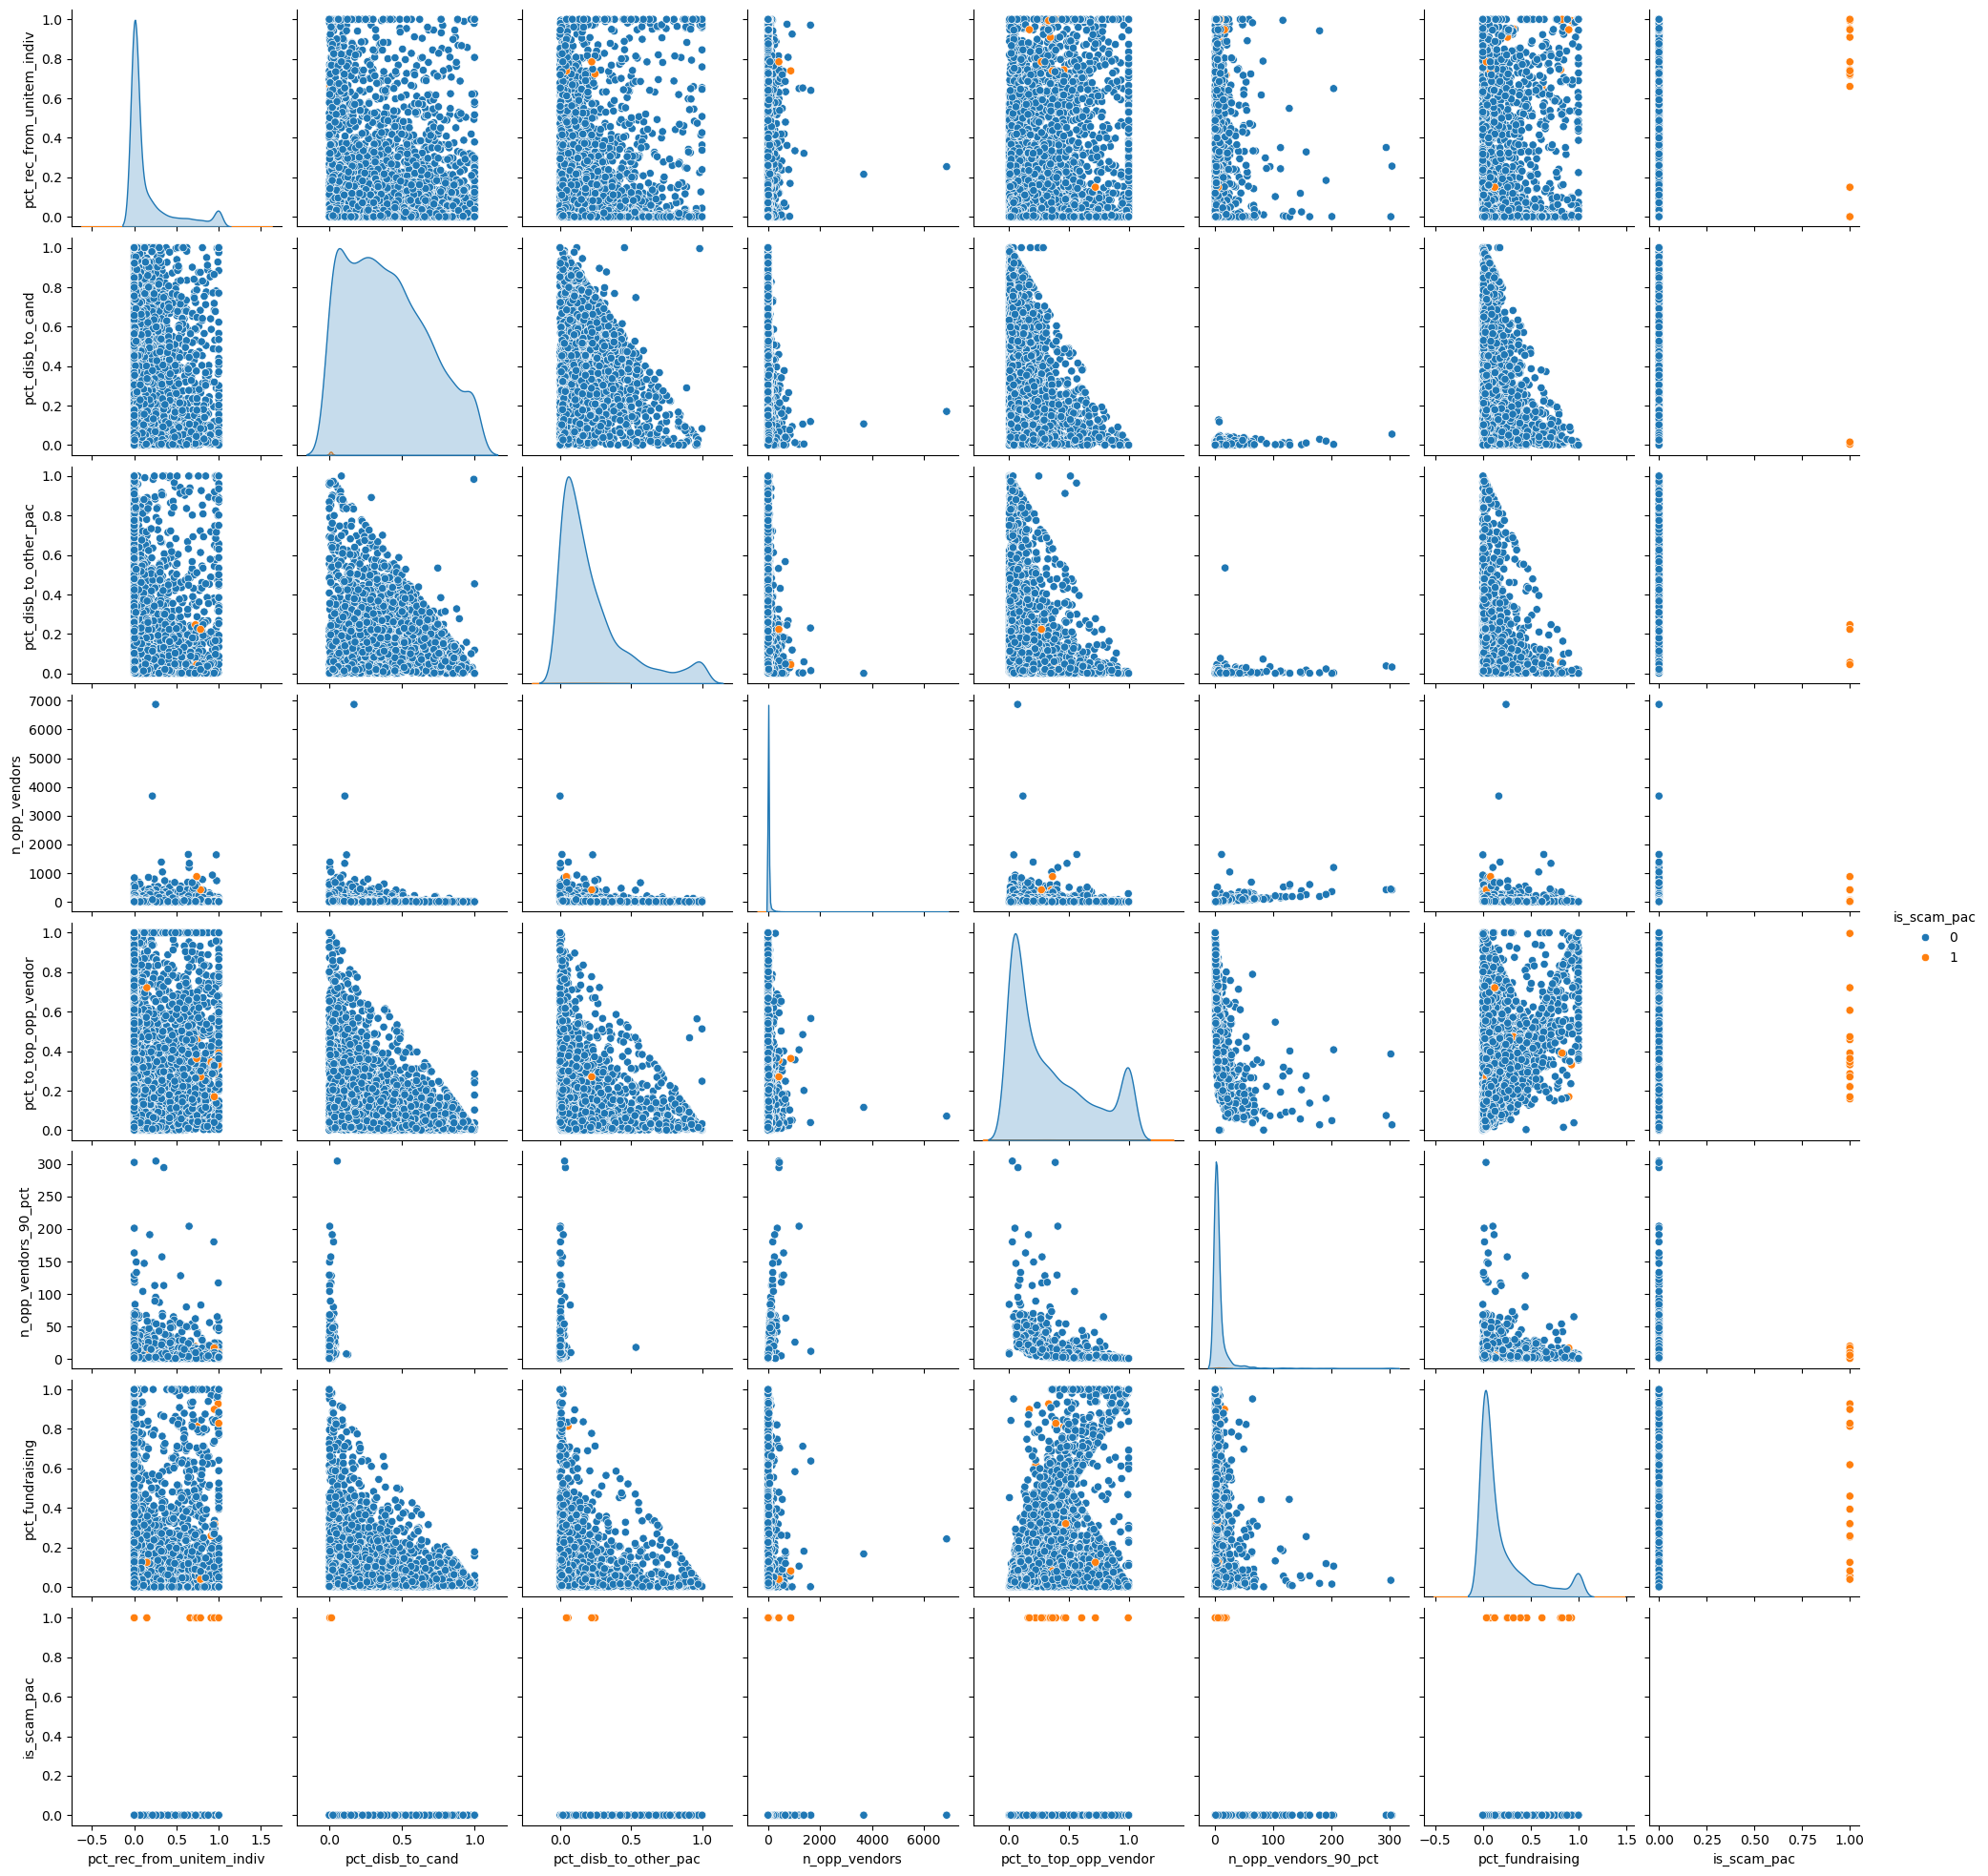

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

pac_data_features = [ 'pct_rec_from_unitem_indiv',
    'pct_disb_to_cand',
       'pct_disb_to_other_pac',  'n_opp_vendors',
       'pct_to_top_opp_vendor',
       'n_opp_vendors_90_pct', 'pct_fundraising', 'is_scam_pac']


sns.pairplot(pac_data_merge, vars=pac_data_merge[pac_data_features], hue='is_scam_pac')
plt.show()

## Export datasets

In [ ]:
sb_data.to_csv('../data/processed/sb_cleaned.csv', index=False)


In [102]:
pac_data_merge.to_csv('../data/processed/pac_data_processed.csv', index=False)


In [ ]:
#### Used in expenditure_purpose_coding.ipynb
sb_data[sb_data['form_type'].isin(['SB21','SB21B','SB29','SB30B'])].to_csv('../data/processed/expenditure_purpose_coding.csv')